In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(42)

In [2]:
# Grid Parameters
nx = 300  # Number of spatial grid points
L = 5.0  # Length of the domain
dt = 0.01  # Time step
a = 1.0 # Advection speed
T = 5.0  # Total simulation time
nt = int(T / dt)  # Number of time steps
dx = L / (nx - 1)  # Spatial resolution

# Grid points
x = np.linspace(0, L, nx)
t = np.linspace(0, T, int(T/dt))

c = a * dt / dx
print(f"Courant Number: {c}")

# Initial condition: Gaussian pulse
def initial_condition(x):
    return np.exp(-((x - L / 4) / 0.1) ** 2)

# NN Parameters
num_nodes = 32
activation = torch.sin
num_epochs = 14000
num_samples = 200

Courant Number: 0.5980000000000001


In [3]:
# Define the neural network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(2, num_nodes)  # Input: (x, t)
        self.fc2 = nn.Linear(num_nodes, num_nodes)
        self.fc3 = nn.Linear(num_nodes, num_nodes)
        self.fc4 = nn.Linear(num_nodes, num_nodes)
        self.fc5 = nn.Linear(num_nodes, num_nodes)
        self.fc6 = nn.Linear(num_nodes, 1)  # Output: u(x, t)

    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)  # Concatenate x and t
        out = activation(self.fc1(inputs))
        out = activation(self.fc2(out))
        out = activation(self.fc3(out))
        out = activation(self.fc4(out))
        out = activation(self.fc5(out))
        out = self.fc6(out)
        return out

# Initialize network and optimizer
model = NeuralNetwork()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define loss functions
def pde_loss(x, t, a):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    return torch.mean((u_t + a * u_x) ** 2)

def ic_loss(x):
    # Detach x and convert to NumPy for initial_condition
    x_np = x.detach().numpy()
    u_true = torch.tensor(initial_condition(x_np), dtype=torch.float32).reshape(-1, 1)
    u_pred = model(x, torch.zeros_like(x))  # Evaluate at t = 0
    return torch.mean((u_pred - u_true) ** 2)

def boundary_loss(t):
    # Sample points at the boundaries (x = 0 and x = L)
    x_left = torch.zeros_like(t)  # x = 0
    x_right = torch.full_like(t, L)  # x = L

    # Evaluate the model at the boundaries
    u_left = model(x_left, t)
    u_right = model(x_right, t)

    # Compute the mean squared error of the difference
    return torch.mean((u_left - u_right) ** 2)

losses = []
# Training loop
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Sample random collocation points
    x_torch = torch.tensor(np.random.uniform(0, L, num_samples), dtype=torch.float32).reshape(-1, 1)
    t_torch = torch.tensor(np.random.uniform(0, T, num_samples), dtype=torch.float32).reshape(-1, 1)

    # Compute losses
    loss_pde = pde_loss(x_torch, t_torch, a)
    loss_ic = ic_loss(x_torch)
    loss_boundary = boundary_loss(t_torch)  # Add boundary loss
    loss = 2*loss_pde + loss_ic + loss_boundary  # Include boundary loss in total loss
    losses.append(loss.detach().numpy())

    # Backpropagation
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}, PDE Loss: {loss_pde.item()}, IC Loss: {loss_ic.item()}, Boundary Loss: {loss_boundary.item()}")

Epoch 0, Loss: 0.026348400861024857, PDE Loss: 0.0006439484423026443, IC Loss: 0.02347954735159874, Boundary Loss: 0.0015809573233127594
Epoch 1000, Loss: 0.0027764253318309784, PDE Loss: 0.0011082415003329515, IC Loss: 0.0002475703659001738, Boundary Loss: 0.000312371994368732
Epoch 2000, Loss: 0.0013984167017042637, PDE Loss: 0.00048178088036365807, IC Loss: 0.00016321703151334077, Boundary Loss: 0.00027163789491169155
Epoch 3000, Loss: 0.0007045933161862195, PDE Loss: 0.00028054293943569064, IC Loss: 3.3685417292872444e-05, Boundary Loss: 0.00010982202365994453
Epoch 4000, Loss: 0.00022348391939885914, PDE Loss: 5.842306563863531e-05, IC Loss: 3.4668497391976416e-05, Boundary Loss: 7.196929072961211e-05
Epoch 5000, Loss: 0.00021309747535269707, PDE Loss: 4.925758548779413e-05, IC Loss: 1.9730860003619455e-05, Boundary Loss: 9.485144255449995e-05
Epoch 6000, Loss: 9.730724559631199e-05, PDE Loss: 1.4511566405417398e-05, IC Loss: 1.3301041690283455e-05, Boundary Loss: 5.49830692762043

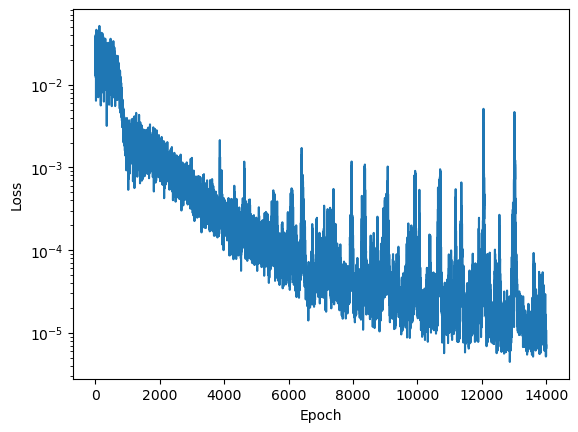

In [4]:
# Plot training
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel ('Loss')
plt.yscale('log')  

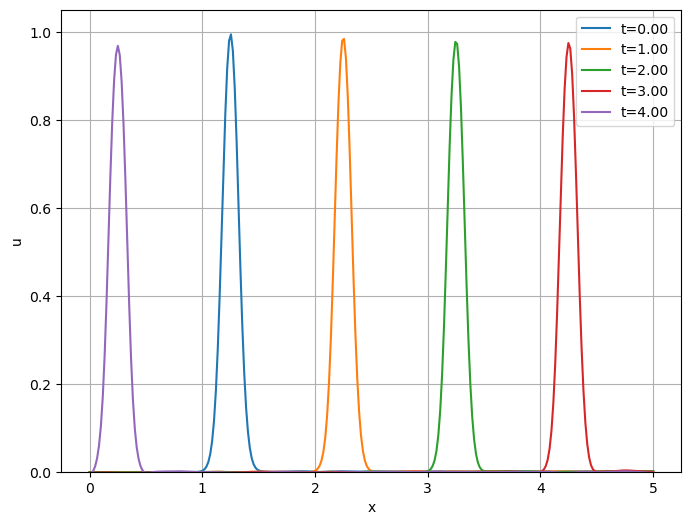

In [ ]:
# Plot the results
plt.figure(figsize=(8, 6))
x_test = torch.tensor(x, dtype=torch.float32).reshape(-1, 1)

# Plot at specific time intervals
for n in range(5):
    t_test = torch.full_like(x_test, n) # Creates a vector with the same shape as x_test with a constant value equal to n
    with torch.no_grad(): 
        u_pred = model(x_test, t_test).detach().numpy()  # Detach tensor before converting to NumPy
    plt.plot(x, u_pred, label=f"t={n:.2f}")

plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.ylim(0.0, 1.05)
plt.grid()
# plt.savefig('Plots/nn_32.png')
plt.show()